# 1D Three Phase Simulation of Alloys and PINN model development 


This notebook contains the simulation of 1D Phase change of aluminium alloy. There will be three phases (solid,liquid and mushy).   

The approach used is finite difference method and the physics involved in heat conduction.

Import Libraries

In [1]:
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import csv
from sklearn import svm
import pandas as pd
import itertools
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from ht_sim import sim1d


from pyDOE2 import fullfact
from pyDOE2 import fracfact

import statsmodels.api as sm

from statsmodels.formula.api import ols



Define the constants and initial conditions

### <center>Pareto analysis</center>

In this section sensitivity study of the soldification and Niyama is performed with respect to different material proerties and their boundary conditions.

A DOE table is created for different factors and their corresponding levels

Here the parameters are as follows:-

Density for material in liquid state $\rho_l$.<br>
Density for material in solid state $\rho_s$.<br>
Latent Heat of Fusion <br>
Specific heat of material in liquid state $C_{pl}$ <br>
Specific heat of material in solid state $C_{ps}$ <br>
Thermal Conductivity of material in liquid state $k_l$<br>
Thermal Conductivity of material in solid state $k_s$ <br>


Boundary conditions:-
BC at Left end,<br>
BC at Right end<br>

Initial Conditions:-

Initial_temperature

The simualtion of the 1D phase change is give temperature and phase change. The output/ target variable under study here is the Average solidification time of the entire geometry.

If Niyama criteria is being considered then some additional input factors are also considered such as:-

Material constant $C_\lambda$
Dynamic Viscosity $\mu_l$



Create a DOE table for Average Solidification Fraction at time t

In [7]:
# Create a full factorial design
num_levels = 2
levels = [0, 1]
num_vars = 10
design = fullfact([num_levels]*num_vars)

# Create a DataFrame from the full factorial design
doe_df_sol_time = pd.DataFrame(design, columns=[f'Var_{i}' for i in range(1, num_vars+1)])
print(doe_df_sol_time.shape)

(1024, 10)


In [8]:
#Create a fractional factorial design

from pyDOE2 import fracfact

num_levels = 2
levels = [0, 1]
num_vars = 10
design2 = fracfact('a b c d e f abcdef abcd bcde adce ')
L_level = 0.99
R_level = 1.01
factor_levels = {
    'rho_l': [2760.0, 2761.0],
    'rho_s': [3000.0, 3001.0],
    'k_l': [96.0, 120.0],
    'k_s': [110.0, 130.0],
    'cp_l': [927.0, 947.0],
    'cp_s': [967.0, 987.0],
    'Left_bc': [313.0, 320.0],
    'right_bc': [400.0, 410.0],
    'L_fusion': [389e3, 400e3 ],
    'temp_init': [880.0, 890.0],

}

factor_names = list(factor_levels.keys())

# Create a DataFrame from the fractional factorial design
doe_df_sol_time_fracfact = pd.DataFrame(design2, columns=factor_names)

for factor, levels in factor_levels.items():
    doe_df_sol_time_fracfact[factor] = doe_df_sol_time_fracfact[factor].map({-1: levels[0], 1: levels[1]})

    
print(doe_df_sol_time_fracfact.shape)

(64, 10)


In [9]:
Res_doe_sol_time = doe_df_sol_time_fracfact.copy()

Res_doe_sol_time['avg_sol_time'] = [0.0] * Res_doe_sol_time.shape[0]

print(Res_doe_sol_time.head(5))



    rho_l   rho_s    k_l    k_s   cp_l   cp_s  Left_bc  right_bc  L_fusion  \
0  2760.0  3000.0   96.0  110.0  927.0  967.0    320.0     410.0  400000.0   
1  2761.0  3000.0   96.0  110.0  927.0  967.0    313.0     400.0  400000.0   
2  2760.0  3001.0   96.0  110.0  927.0  967.0    313.0     400.0  389000.0   
3  2761.0  3001.0   96.0  110.0  927.0  967.0    320.0     410.0  389000.0   
4  2760.0  3000.0  120.0  110.0  927.0  967.0    313.0     400.0  389000.0   

   temp_init  avg_sol_time  
0      890.0           0.0  
1      880.0           0.0  
2      890.0           0.0  
3      880.0           0.0  
4      880.0           0.0  


Function for simulation

In [10]:
# here the response values are calculated using sim1d function

for i in range(Res_doe_sol_time.shape[0]):
    input_values = Res_doe_sol_time.iloc[i,:-1].values
    Res_doe_sol_time.at[i, 'avg_sol_time'] = sim1d(*input_values)

Number of time steps: 54626
Number of time steps: 54626
Number of time steps: 54607
Number of time steps: 54607
Number of time steps: 67568
Number of time steps: 67544
Number of time steps: 67568
Number of time steps: 67544
Number of time steps: 64557
Number of time steps: 64557
Number of time steps: 64536
Number of time steps: 64536
Number of time steps: 67568
Number of time steps: 67544
Number of time steps: 67568
Number of time steps: 67544
Number of time steps: 54626
Number of time steps: 54626
Number of time steps: 54607
Number of time steps: 54607
Number of time steps: 66141
Number of time steps: 66117
Number of time steps: 66141
Number of time steps: 66117
Number of time steps: 64557
Number of time steps: 64557
Number of time steps: 64536
Number of time steps: 64536
Number of time steps: 66141
Number of time steps: 66117
Number of time steps: 66141
Number of time steps: 66117
Number of time steps: 54055
Number of time steps: 54035
Number of time steps: 54055
Number of time steps

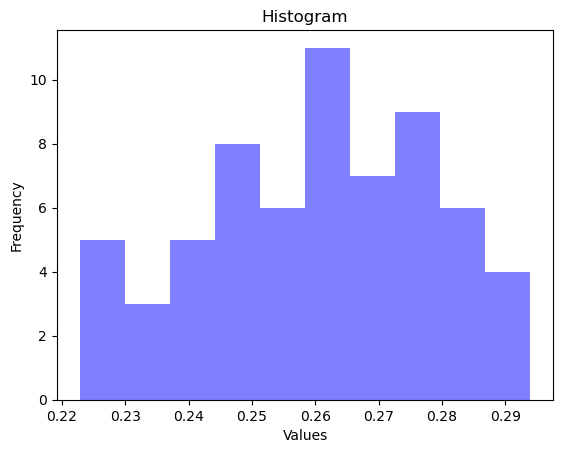

In [11]:
plt.hist(Res_doe_sol_time['avg_sol_time'], bins=10, alpha=0.5, color='b')
plt.title('Histogram')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

Regression of the DOE-Soldifcation time

In [29]:


# Create the formula for the ANOVA
formula = 'avg_sol_time ~ C(rho_l) + C(rho_s) + C(k_l) + C(k_s) + C(cp_l) + C(cp_s) + C(Left_bc) + C(right_bc) + C(L_fusion) + C(temp_init)'

# Fit the model
model = sm.GLS.from_formula(formula, data=Res_doe_sol_time).fit()
print(model.summary())


                            GLS Regression Results                            
Dep. Variable:           avg_sol_time   R-squared:                       0.957
Model:                            GLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     118.4
Date:                Fri, 07 Jun 2024   Prob (F-statistic):           1.37e-32
Time:                        09:52:53   Log-Likelihood:                 265.68
No. Observations:                  64   AIC:                            -509.4
Df Residuals:                      53   BIC:                            -485.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

## Anova Results

In [30]:

# Perform ANOVA
anova_results = sm.stats.anova_lm(model, typ=2)

# Display the ANOVA results
print(anova_results)


                    sum_sq    df           F        PR(>F)
C(rho_l)      1.181413e-07   1.0    0.006741  9.348729e-01
C(rho_s)      8.780284e-09   1.0    0.000501  9.822264e-01
C(k_l)        1.087675e-02   1.0  620.627942  6.238128e-31
C(k_s)        4.202742e-03   1.0  239.808615  2.559900e-21
C(cp_l)       2.143373e-04   1.0   12.230092  9.601846e-04
C(cp_s)       3.078488e-04   1.0   17.565864  1.056779e-04
C(Left_bc)    1.467544e-05   1.0    0.837381  3.642916e-01
C(right_bc)   3.840404e-05   1.0    2.191336  1.447093e-01
C(L_fusion)   4.433991e-03   1.0  253.003689  7.924435e-22
C(temp_init)  6.664859e-04   1.0   38.029706  9.813808e-08
Residual      9.288463e-04  53.0         NaN           NaN


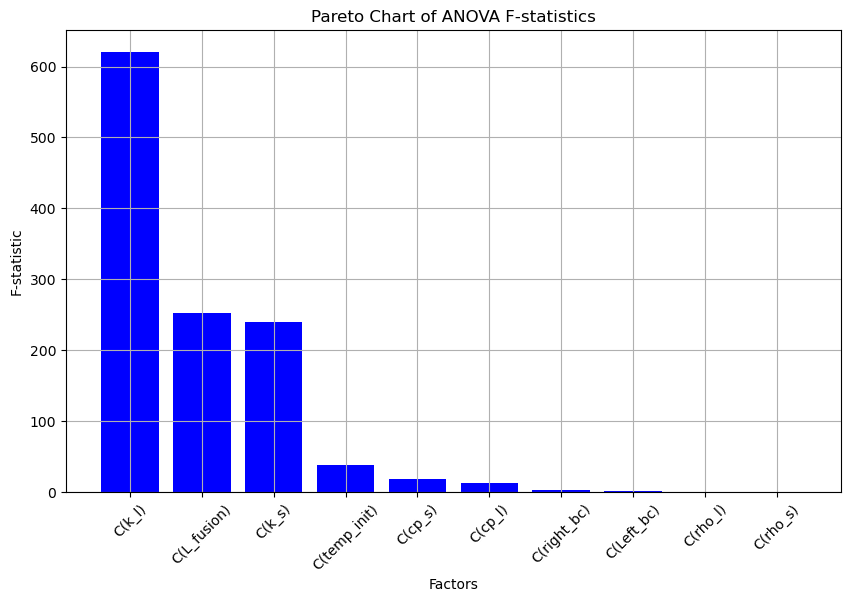

In [31]:
# Create a DataFrame from the ANOVA results
anova_results_df = anova_results.reset_index()

# Sort by the F-statistic or sum of squares for visualization
anova_results_df = anova_results_df.sort_values(by='F', ascending=False)

# Plot the Pareto chart
plt.figure(figsize=(10, 6))
plt.bar(anova_results_df['index'], anova_results_df['F'], color='b')
plt.xlabel('Factors')
plt.ylabel('F-statistic')
plt.title('Pareto Chart of ANOVA F-statistics')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Main effects Plot

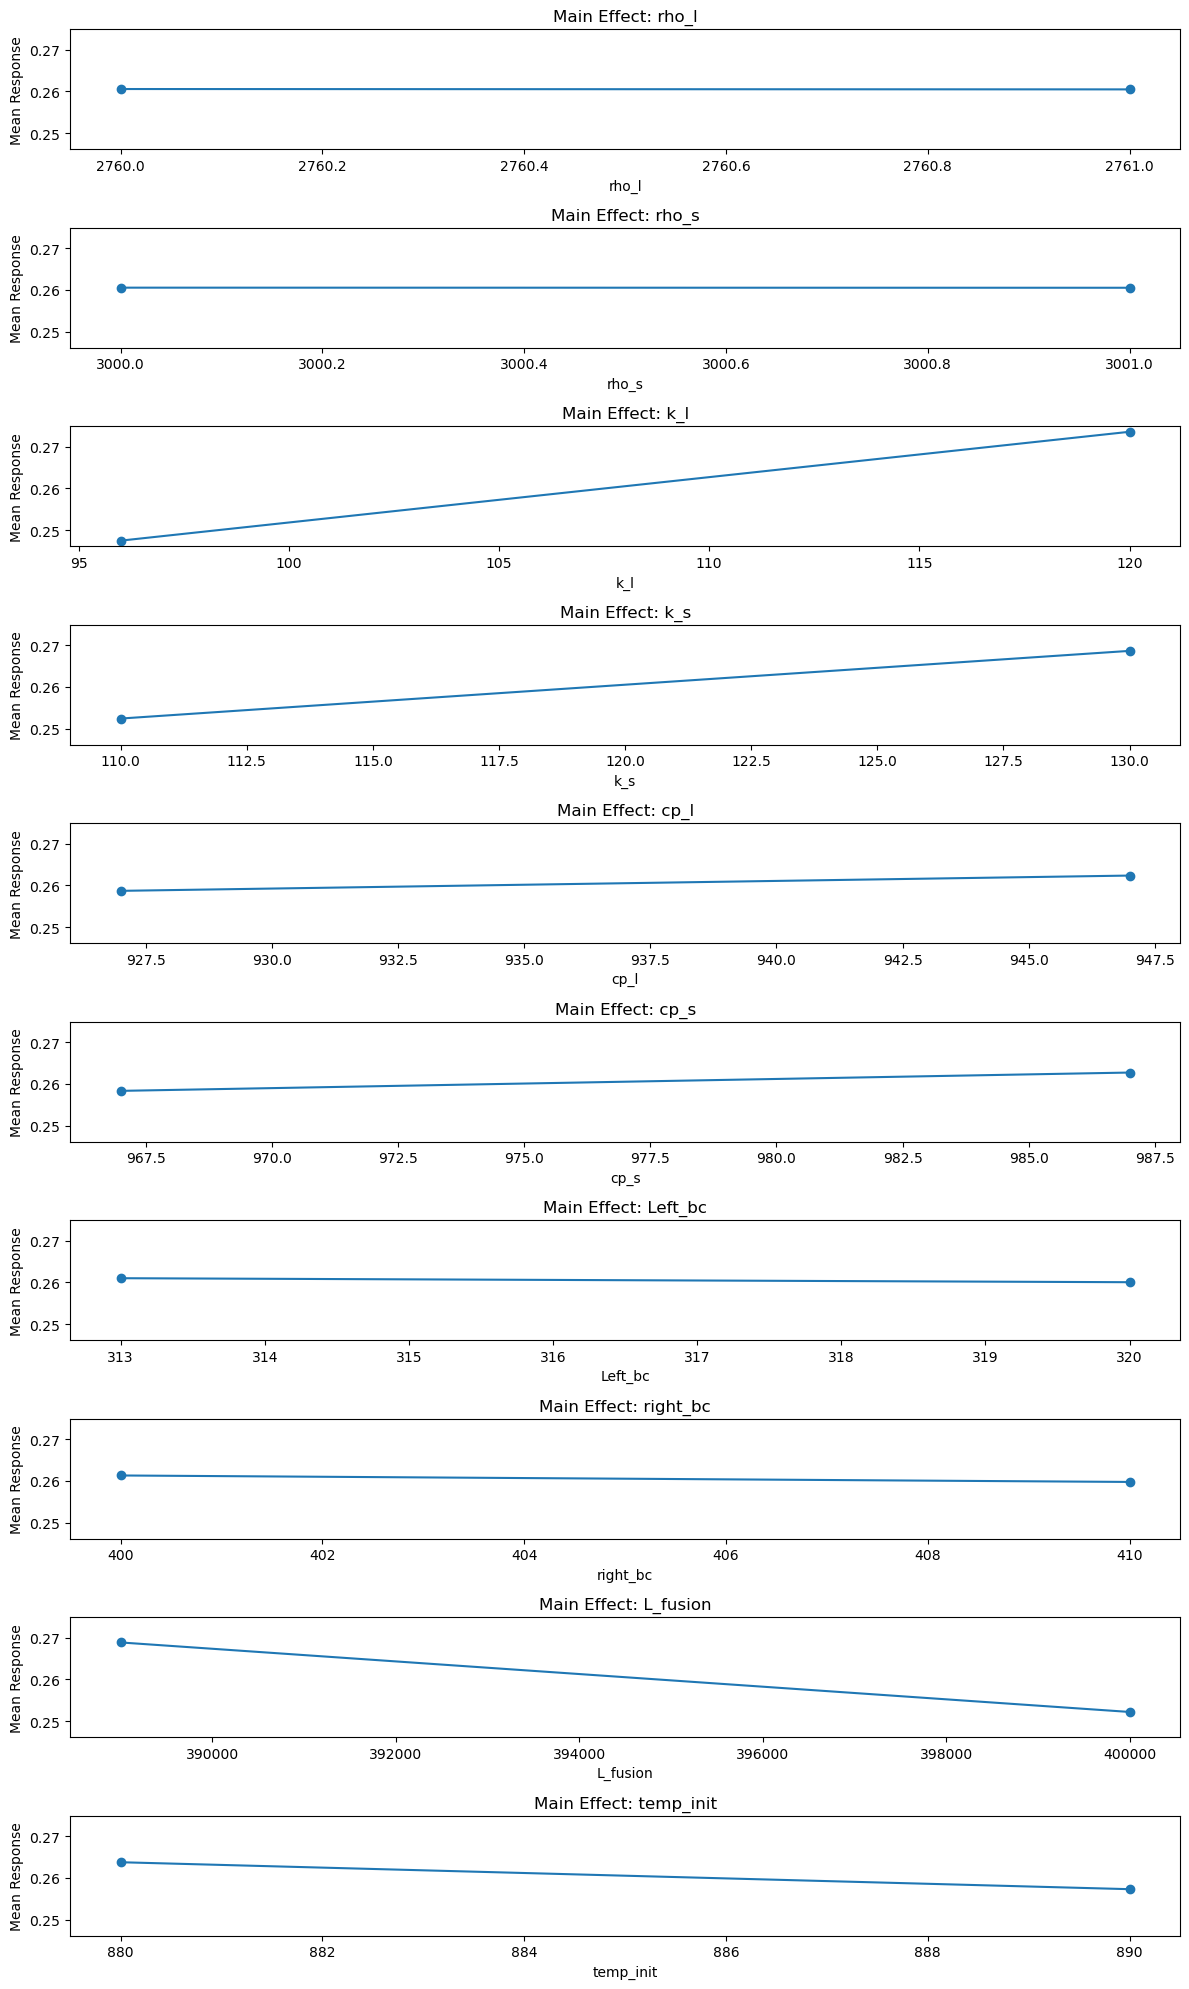

In [32]:
# Main effects plot
def main_effects_plot(model, data, factors):
    num_factors = len(factors)
    fig, axes = plt.subplots(num_factors,1, figsize=(12,num_factors* 2), sharey=True)
    if num_factors == 1:
        axes = [axes]
    for i, factor in enumerate(factors):
        means = data.groupby(factor)['avg_sol_time'].mean()
        axes[i].plot(means.index, means.values, marker='o')
        axes[i].set_title(f'Main Effect: {factor}')
        axes[i].set_xlabel(factor)
        axes[i].set_ylabel('Mean Response')
    plt.tight_layout()
    plt.show()

main_effects_plot(model, Res_doe_sol_time, factor_names)

Interactions Plot

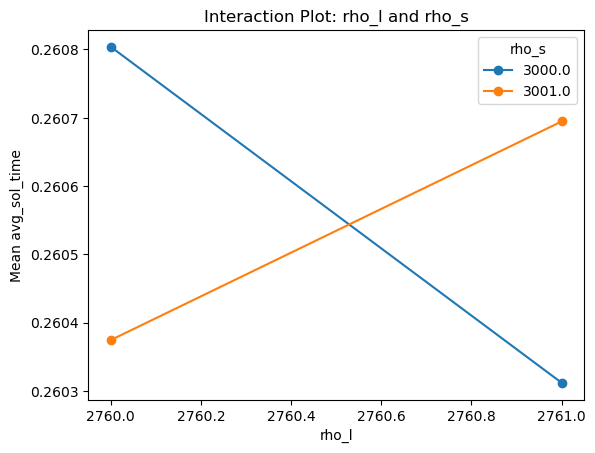

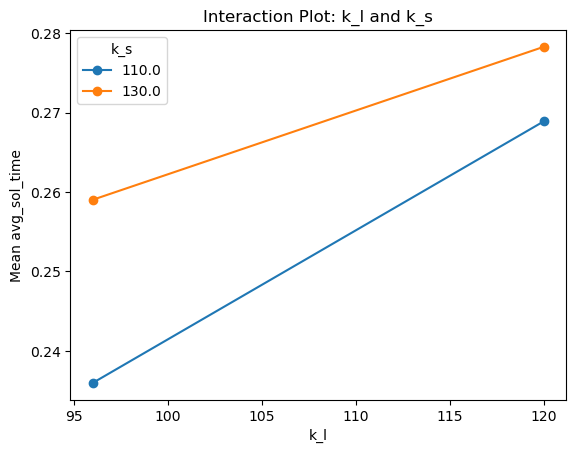

In [16]:
import seaborn as sns

# Interaction plot
def interaction_plot(data, factor1, factor2, response):
    interaction = data.groupby([factor1, factor2])[response].mean().unstack()
    interaction.plot(kind='line', marker='o')
    plt.title(f'Interaction Plot: {factor1} and {factor2}')
    plt.xlabel(factor1)
    plt.ylabel(f'Mean {response}')
    plt.legend(title=factor2)
    plt.show()

# Example interaction plots for a couple of factor pairs
interaction_plot(Res_doe_sol_time, 'rho_l', 'rho_s', 'avg_sol_time')
interaction_plot(Res_doe_sol_time, 'k_l', 'k_s', 'avg_sol_time')

Adding centre points

In [22]:
num_centers = 1

center_point = {factor: np.mean (levels) for factor,levels in factor_levels.items()}
center_points = pd.DataFrame([center_point]*num_centers)

doe_with_centers = pd.concat([doe_df_sol_time_fracfact, center_points], ignore_index=True)

print(doe_with_centers.shape)
print(doe_with_centers)

(65, 10)
     rho_l   rho_s    k_l    k_s   cp_l   cp_s  Left_bc  right_bc  L_fusion  \
0   2760.0  3000.0   96.0  110.0  927.0  967.0    320.0     410.0  400000.0   
1   2761.0  3000.0   96.0  110.0  927.0  967.0    313.0     400.0  400000.0   
2   2760.0  3001.0   96.0  110.0  927.0  967.0    313.0     400.0  389000.0   
3   2761.0  3001.0   96.0  110.0  927.0  967.0    320.0     410.0  389000.0   
4   2760.0  3000.0  120.0  110.0  927.0  967.0    313.0     400.0  389000.0   
..     ...     ...    ...    ...    ...    ...      ...       ...       ...   
60  2760.0  3000.0  120.0  130.0  947.0  987.0    320.0     410.0  389000.0   
61  2761.0  3000.0  120.0  130.0  947.0  987.0    313.0     400.0  389000.0   
62  2760.0  3001.0  120.0  130.0  947.0  987.0    313.0     400.0  400000.0   
63  2761.0  3001.0  120.0  130.0  947.0  987.0    320.0     410.0  400000.0   
64  2760.5  3000.5  108.0  120.0  937.0  977.0    316.5     405.0  394500.0   

    temp_init  
0       890.0  
1       88

In [26]:
Res_doe_sol_time_center = doe_with_centers.copy()

Res_doe_sol_time_center['avg_sol_time'] = [0.0] * Res_doe_sol_time_center.shape[0]

print(Res_doe_sol_time_center.head(5))

    rho_l   rho_s    k_l    k_s   cp_l   cp_s  Left_bc  right_bc  L_fusion  \
0  2760.0  3000.0   96.0  110.0  927.0  967.0    320.0     410.0  400000.0   
1  2761.0  3000.0   96.0  110.0  927.0  967.0    313.0     400.0  400000.0   
2  2760.0  3001.0   96.0  110.0  927.0  967.0    313.0     400.0  389000.0   
3  2761.0  3001.0   96.0  110.0  927.0  967.0    320.0     410.0  389000.0   
4  2760.0  3000.0  120.0  110.0  927.0  967.0    313.0     400.0  389000.0   

   temp_init  avg_sol_time  
0      890.0           0.0  
1      880.0           0.0  
2      890.0           0.0  
3      880.0           0.0  
4      880.0           0.0  


In [28]:
model_center = sm.GLS.from_formula(formula, data=Res_doe_sol_time_center).fit()
print(model_center.summary())




                            GLS Regression Results                            
Dep. Variable:           avg_sol_time   R-squared:                         nan
Model:                            GLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 07 Jun 2024   Prob (F-statistic):                nan
Time:                        09:51:06   Log-Likelihood:                    inf
No. Observations:                  65   AIC:                              -inf
Df Residuals:                      53   BIC:                              -inf
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1870: RuntimeWarning: invalid value encountered in scalar divide
  return self.mse_model/self.mse_resid
/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:605: RuntimeWarning: divide by zero encountered in log
  llf = -np.log(SSR) * nobs2      # concentrated likelihood
/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in scalar divide
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)


In [25]:
# Identify center points
center_points = Res_doe_sol_time_center.iloc[-num_centers:, :]
print(center_points)
factorial_points = Res_doe_sol_time_center.iloc[:-num_centers, :]

# Calculate mean responses
mean_center_response = center_points['avg_sol_time'].mean()
mean_factorial_response = factorial_points['avg_sol_time'].mean()

print(f'Mean Center Response: {mean_center_response}')
print(f'Mean Factorial Response: {mean_factorial_response}')

     rho_l   rho_s    k_l    k_s   cp_l   cp_s  Left_bc  right_bc  L_fusion  \
64  2760.5  3000.5  108.0  120.0  937.0  977.0    316.5     405.0  394500.0   

    temp_init  avg_sol_time  
64      885.0           0.0  
Mean Center Response: 0.0
Mean Factorial Response: 0.0


In [21]:
from scipy.stats import ttest_ind
# Perform a t-test to check for significant difference
t_stat, p_value = ttest_ind(center_points['avg_sol_time'], factorial_points['avg_sol_time'])

print(f'T-test statistic: {t_stat}')
print(f'P-value: {p_value}')

if p_value < 0.05:
    print('Significant curvature detected in the response surface.')
else:
    print('No significant curvature detected in the response surface.')

T-test statistic: nan
P-value: nan
No significant curvature detected in the response surface.
